# House Hunters Linear Model

Linear regression model of human-interpretable features that will make recommendations for people looking to buy or sell a house.

## Pre-Processing

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp

# set display options
pd.set_option('display.max_columns', None)

In [2]:
# import dataset
housing = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0)
# real_estate = pd.read_csv('./data/Ames_Real_Estate_Data.csv')

In [3]:
housing

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,TA,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,TA,4,Typ,1,Gd,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
2,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
3,911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,9,1930,2007,Hip,CompShg,MetalSd,MetalSd,None,0.0,Gd,TA,BrkTil,TA,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,Ex,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,Gd,5,Typ,0,NaN,Detchd,1930.0,Unf,1.0,216.0,TA,Po,N,154,0,42,86,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
4,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,Gd,BrkTil,Fa,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,Gd,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
5,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,8,6,2001,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,643.0,Unf,0.0,167.0,810.0,GasA,Ex,Y,SBrkr,810,855,0,1.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,2001.0,Fin,2.0,528.0,TA,TA,Y,0,45,0,0,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,903205040,952,121000,30,RL,NaN,8854,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Unf,6,6,1916,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,Grav,Fa,N,FuseF,952,0,0,0.0,0.0,1,0,2,1,Fa,4,Typ,1,Gd,Detchd,1916.0,Unf,1.0,192.0,Fa,Po,P,0,98,0,0,40,0,NaN,NaN,NaN,0,5,2009,WD,Normal
760,905402060,1733,139600,20,RL,NaN,13680,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,1Fam,1Story,3,5,1955,1955,Hip,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Ex,Y,FuseA,1733,0,0,0.0,0.0,2,0,4,1,TA,8,Min2,1,Gd,Attchd,1955.0,Unf,2.0,452.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
761,909275030,2002,145000,90,RH,82.0,6270,Pave,NaN,Reg,HLS,AllPub,Inside,Gtl,Crawfor,Norm,Norm,Duplex,2Story,5,6,1949,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,284.0,Unf,0.0,717.0,1001.0,GasA,TA,N,FuseA,1001,1001,0,0.0,0.0,2,0,4,2,TA,8,Typ,0,NaN,2Types,1949.0,Unf,3.0,871.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
762,907192040,1842,217500,60,RL,N

#### Feature Cleaning

In [3]:
#Remove Outliers
housing = housing[np.logical_and(housing.SalePrice >= 40000, housing.SalePrice <= 750000)]
housing = housing[housing.GrLivArea < 4000]
housing = housing[housing.BedroomAbvGr > 0]
housing.loc[housing['GarageCars'] == 5, 'GarageCars'] = 4

#Remove Bad Classes
housing = housing[housing.Neighborhood != 'Landmrk']

housing.MSZoning = housing.MSZoning.astype('string')
housing.MSZoning = housing.MSZoning.str.strip()
housing = housing[housing.MSZoning.isin(["FV", "RH", "RL", "RM"])]

housing = housing[housing.Functional.isin(["Typ", "Min1", "Min2"])]

housing.SaleType = housing.SaleType.astype('string')
housing.SaleType = housing.SaleType.str.strip()
housing = housing[housing.SaleType == 'WD']

housing = housing[housing.SaleCondition == 'Normal']


#Replace NAs
housing = housing.fillna(0)

#### Feature Engineering

In [4]:
#Area Calculations
housing['PorchTotSF'] = housing.OpenPorchSF + housing.EnclosedPorch + housing['3SsnPorch'] + housing.ScreenPorch
housing['BsmtSF'] = housing.BsmtFinSF1 + housing.BsmtFinSF2
housing.loc[housing['BsmtSF'] == 0, 'BsmtSF'] = exp(1)

#Log Transforms
housing['LogSalePrice'] = np.log(housing.SalePrice)
housing['LogLotArea'] = np.log(housing.LotArea)
housing['LogGrLivArea'] = np.log(housing.GrLivArea)
housing['LogBsmtSF'] = np.log(housing.BsmtSF)

#Categorical to Ordinal
housing.Neighborhood = housing.Neighborhood.replace({'MeadowV':1,'BrDale':2, 'IDOTRR':3, 'BrkSide':4, 'OldTown':5, 'Edwards':6, 'SWISU':7, 'Landmrk':8, 'Sawyer':9,\
                           'NPkVill':10, 'Blueste':11, 'NAmes':12, 'Mitchel':13, 'SawyerW':14, 'Gilbert':15, 'NWAmes':16, 'Greens':17, 'Blmngtn':18,\
                           'CollgCr':19, 'Crawfor':20, 'ClearCr':21, 'Somerst':22, 'Timber':23, 'Veenker':24, 'GrnHill':25, 'StoneBr':26,'NridgHt':27, 'NoRidge':28})
housing.BldgType = housing.BldgType.replace({'2fmCon':1,'Twnhs':2, 'Duplex':3, '1Fam':4, 'TwnhsE':5})
housing.HouseStyle = housing.HouseStyle.replace({'1.5Unf':1,'1.5Fin':2, 'SFoyer':3, 'SLvl':4, '1Story':5, '2.5Unf':6, '2Story':7, '2.5Fin':8})
housing.MoSold = housing.MoSold.replace({1:11, 9:10, 8:9, 6:8, 7:7, 11:6, 12:5, 2:4, 3:3, 10:2, 5:1, 4:0})

#Renumber Numerical
housing['NumBath'] = housing.FullBath + 0.5*housing.HalfBath + 0.5*housing.BsmtFullBath

#Binary HasBLANK Categories
housing['BeenRemod'] = np.where(housing.YearBuilt != housing.YearRemodAdd, 1, 0)
housing['HasFinBsmt'] = np.where(housing.BsmtFinSF1 > 0, 1, 0)
housing['HasFinGarage'] = np.where(housing.GarageFinish == "Fin", 1, 0)
housing['HasPool'] = np.where(housing.PoolArea > 0, 1, 0)
housing['HasFireplace'] = np.where(housing.Fireplaces > 0, 1, 0)
housing['HasPorch'] = np.where(housing.PorchTotSF > 0, 1, 0)
housing['HasDeck'] = np.where(housing.WoodDeckSF > 0, 1, 0)


#Binary Quality/Cond Categories
housing['AttachedGarage'] = np.where(housing.GarageType == "Attchd", 1, 0)
housing['GreatElectric'] = np.where(housing.Electrical == "SBrkr", 1, 0)
housing['GreatHeat'] = np.where(housing.HeatingQC == "Ex", 1, 0)
housing['CentralAir'] = np.where(housing.CentralAir == "Y", 1, 0)

#### Feature Selection

In [5]:
model_cols = ['LogSalePrice', 'LogLotArea', 'LogGrLivArea', 'LogBsmtSF', 'OverallQual', 'OverallCond', 'YearBuilt',\
              'Neighborhood', 'BldgType', 'HouseStyle', 'MoSold', 'NumBath', 'GarageCars', 'BedroomAbvGr',\
              'BeenRemod', 'HasFinBsmt', 'HasFinGarage', 'HasPool', 'HasFireplace', 'HasPorch', 'HasDeck',\
              'AttachedGarage', 'GreatElectric', 'GreatHeat', 'CentralAir']
housing = housing[model_cols]

## Model Generation

In [24]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import model_selection

In [7]:
y = housing['LogSalePrice']
x = housing.drop('LogSalePrice', axis=1)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=.2, random_state=0)

lm = LinearRegression()
lm.fit(x_train, y_train)

print(lm.score(x_train, y_train))
print(lm.score(x_test, y_test))
print(lm.coef_)

0.9199308325342063
0.9236199354291402
[ 9.27327073e-02  4.67985294e-01  4.39133320e-02  7.18724949e-02
  4.59541323e-02  2.16733925e-03  7.82057043e-03  1.04898002e-02
 -7.85741492e-03  1.32503140e-03  1.49201415e-03  4.02823721e-02
 -2.61653402e-02  1.84865930e-03 -1.52443546e-01  1.56838337e-02
  1.14880150e-01  2.44327410e-02  1.68908778e-02  1.56180026e-02
 -3.70010899e-04  1.29045391e-02  3.88929693e-02  4.29182814e-02]


Lasso(alpha=0.0003430469286314919, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': 0.0003430469286314919}
0.9191468662219423


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

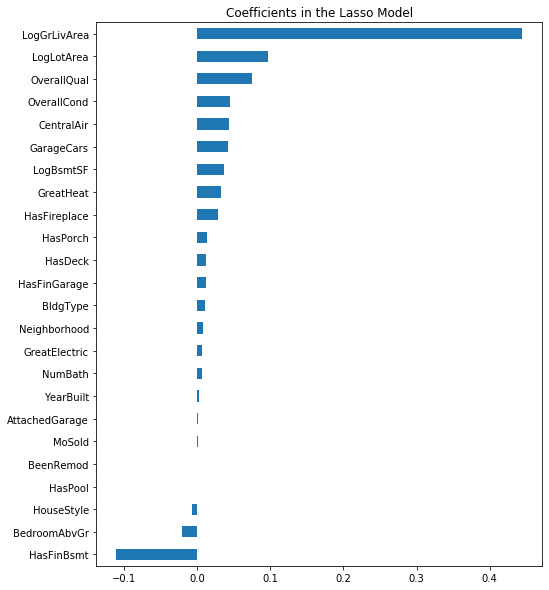

In [33]:
param_grid={'alpha': np.logspace(-5, -3, 100)}
grid_search = model_selection.GridSearchCV(estimator = Lasso(), param_grid = param_grid, cv=3)
grid_search.fit(x, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

alpha_cv = grid_search.best_estimator_.get_params()['alpha']

lasso = Lasso(alpha = alpha_cv).fit(x, y)
coef = pd.Series(lasso.coef_, index = x.columns)
imp_coef = pd.concat([coef.sort_values()])
imp_coef.plot(kind = "barh", figsize = (8, 10))
plt.title("Coefficients in the Lasso Model")

Lasso(alpha=0.0003944206059437656, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': 0.0003944206059437656}
0.9138968969242178


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

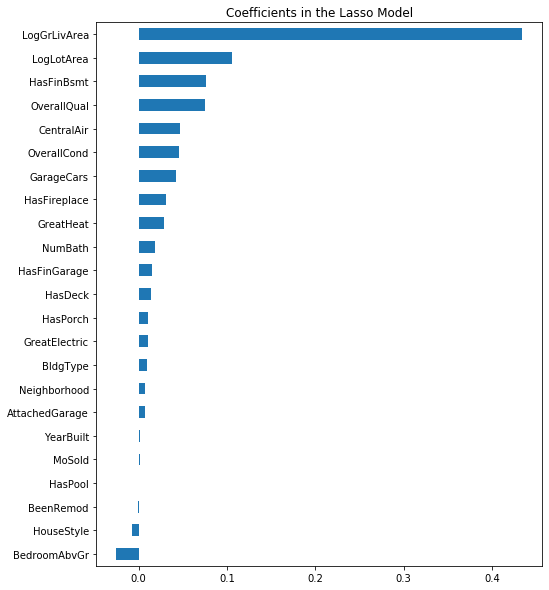

In [35]:
x = housing.drop(['LogSalePrice', 'LogBsmtSF'], axis=1)
grid_search.fit(x, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

alpha_cv = grid_search.best_estimator_.get_params()['alpha']

lasso = Lasso(alpha = alpha_cv).fit(x, y)
coef = pd.Series(lasso.coef_, index = x.columns)
imp_coef = pd.concat([coef.sort_values()])
imp_coef.plot(kind = "barh", figsize = (8, 10))
plt.title("Coefficients in the Lasso Model")

Lasso(alpha=0.00021544346900318845, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': 0.00021544346900318845}
0.9107207672949951


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

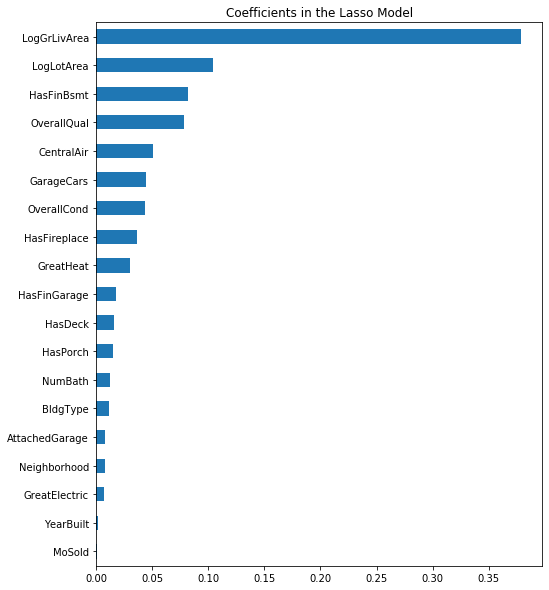

In [36]:
x = housing.drop(['LogSalePrice', 'LogBsmtSF', 'HasPool', 'HouseStyle', 'BedroomAbvGr', 'BeenRemod'], axis=1)
grid_search.fit(x, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

alpha_cv = grid_search.best_estimator_.get_params()['alpha']

lasso = Lasso(alpha = alpha_cv).fit(x, y)
coef = pd.Series(lasso.coef_, index = x.columns)
imp_coef = pd.concat([coef.sort_values()])
imp_coef.plot(kind = "barh", figsize = (8, 10))
plt.title("Coefficients in the Lasso Model")

Lasso(alpha=9.326033468832199e-05, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': 9.326033468832199e-05}
0.9052701914364283


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

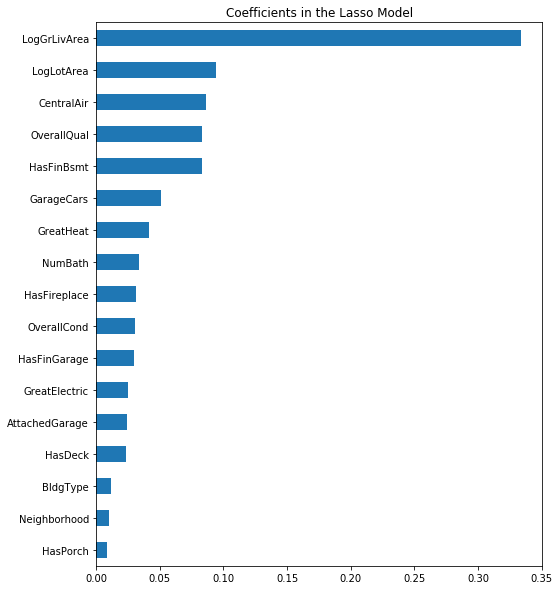

In [38]:
x = housing.drop(['LogSalePrice', 'LogBsmtSF', 'HasPool', 'HouseStyle', 'BedroomAbvGr', \
                  'BeenRemod', 'YearBuilt', 'MoSold'], axis=1)
grid_search.fit(x, y)

print(grid_search.best_estimator_)
print(grid_search.best_params_)
print(grid_search.best_score_)

alpha_cv = grid_search.best_estimator_.get_params()['alpha']

lasso = Lasso(alpha = alpha_cv).fit(x, y)
coef = pd.Series(lasso.coef_, index = x.columns)
imp_coef = pd.concat([coef.sort_values()])
imp_coef.plot(kind = "barh", figsize = (8, 10))
plt.title("Coefficients in the Lasso Model")

## Model Deployment

#### Buyer Profile:

In [ ]:
Budget = 100000
LivArea = 100000
HasGarage = 0
HasPool = 1
HasPorch = 1

buyer_data = [np.log(Budget), np.log(LivArea), HasGarage, HasPool, HasPorch]
buyer_cols = keep

buyer = pd.DataFrame(data = buyer_data, columns = buyer_cols)

#### Buyer Recomendation Tool:

In [ ]:
from math import exp

def buyer_recommendation(buyer, model):
    
    #generate intial estimate
    budget = buyer['LogSalePrice']
    buyer = buyer.drop('LogSalePrice', axis=1)
    base_value = exp(model.predict(buyer))
    
    print('Your budget is: ', budget)
    print('Based on your profile, the house you want will cost: ', base_value)
    
    #search for ways to find a good deal
    recommendation = []
    
    #if over budget, do a grid search for ways to reduce cost
        #for feature in list:
            #if buyer[feature] == 1:
                buyer[feature] = 0
                new_value = exp(model.predict(buyer))
                savings = base_value - new_value
                recommendation.append(savings, feature)
        print('If you are willing to compromise on these features, you could save this much money:')
        print(recommendation)
        
    #if under budget, do a grid search for way to optimize cost
        #for feature in list:
            #if buyer[feature] == 0:
                buyer[feature] = 1
                new_value = exp(model.predict(buyer))
                if new_value < budget:
                    stretch = new_value - base_value
                    recommendation.append(stretch, feature)
        print('If you want, you could add these features without going over budget:')
        print(recommendation)
        
    #neighborhood search
    
    #square footage search
    
    #month of year search

#### Seller Profile:

In [ ]:
LivArea = 100000
HasGarage = 0
HasPool = 1
HasPorch = 1

seller_data = [np.log(LivArea), HasGarage, HasPool, HasPorch]
seller_cols = keep[1:]

buyer = pd.DataFrame(data = seller_data, columns = seller_cols)

#### Seller Recommedation Tool:

In [ ]:
def seller_recommendation(seller, model):
    
    #generate intial estimate
    budget = buyer['LogSalePrice']
    buyer = buyer.drop('LogSalePrice', axis=1)
    base_value = exp(model.predict(buyer))
    
    print('Your budget is: ', budget)
    print('Based on your profile, the house you want will cost: ', base_value)
    
    #search for ways to find a good deal
    recommendation = []
    
    #if over budget, do a grid search for ways to reduce cost
        #for feature in list:
            #if buyer[feature] == 1:
                buyer[feature] = 0
                new_value = exp(model.predict(buyer))
                savings = base_value - new_value
                recommendation.append(savings, feature)
        print('If you are willing to compromise on these features, you could save this much money:')
        print(recommendation)
        
    #if under budget, do a grid search for way to optimize cost
        #for feature in list:
            #if buyer[feature] == 0:
                buyer[feature] = 1
                new_value = exp(model.predict(buyer))
                if new_value < budget:
                    stretch = new_value - base_value
                    recommendation.append(stretch, feature)
        print('If you want, you could add these features without going over budget:')
        print(recommendation)
        
    #neighborhood search
    
    #square footage search
    
    #month of year search